In [109]:
import tensorflow as tf
import keras
import retina
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics

In [110]:
df = pd.read_csv(retina.filesys.TRAINING_DATA_CSV_PATH, index_col=False)
labels = df["label"]
df = df.drop(columns=["label"])
df = df.loc[:,tuple(filter(lambda x: x.startswith("texture"), df.columns))]
df

,texture-1,texture-2,texture-3,texture-4,texture-5,texture-6,texture-7,texture-8,texture-9,texture-10,...,texture-375,texture-376,texture-377,texture-378,texture-379,texture-380,texture-381,texture-382,texture-383,texture-384
0,0.006944,0.001528,0.001458,0.000694,0.001319,0.003681,0.007569,0.000903,0.001875,0.000069,...,0.001181,0.001250,0.002153,0.002083,0.006597,0.003472,0.001875,0.000903,0.000833,0.001944
1,0.007153,0.003681,0.001042,0.000278,0.001389,0.002083,0.007153,0.001111,0.002014,0.000139,...,0.003194,0.000278,0.001042,0.002500,0.004931,0.002361,0.001042,0.003611,0.001667,0.002014
2,0.009444,0.002292,0.000903,0.000556,0.001250,0.001181,0.008542,0.001250,0.001944,0.000278,...,0.001597,0.000069,0.001042,0.002500,0.007083,0.001389,0.001250,0.001458,0.001944,0.002500
3,0.007083,0.000972,0.000833,0.000903,0.001250,0.004583,0.009583,0.000625,0.000764,0.000417,...,0.001250,0.000347,0.000417,0.000347,0.006389,0.003194,0.000972,0.001319,0.001736,0.002014
4,0.004306,0.002778,0.002153,0.000208,0.004097,0.002083,0.008819,0.001250,0.002222,0.000625,...,0.001250,0.000903,0.001875,0.003333,0.008194,0.003472,0.000972,0.000764,0.001042,0.001181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,0.003958,0.002569,0.001944,0.000486,0.000972,0.005694,0.004167,0.000694,0.001806,0.000347,...,0.001597,0.001736,0.002431,0.002014,0.004375,0.004514,0.001806,0.000972,0.001042,0.002917
408,0.003819,0.001181,0.001389,0.000139,0.002292,0.006806,0.003264,0.001528,0.002292,0.000208,...,0.001250,0.002569,0.002500,0.002500,0.004097,0.002222,0.002083,0.000625,0.003333,0.003264
409,0.004514,0.000764,0.000833,0.000486,0.001667,0.007361,0.004306,0.001528,0.001875,0.000208,...,0.001250,0.001597,0.002222,0.002708,0.005694,0.001042,0.001389,0.001806,0.003611,0.002083
410,0.004653,0.001736,0.002431,0.000347,0.001458,0.005000,0.003889,0.001736,0.002222,0.000278,...,0.001736,0.001181,0.001597,0.001806,0.005486,0.002361,0.000903,0.001319,0.001944,0.003611


In [111]:
dataset = tf.data.Dataset.from_tensor_slices((df, labels))
train_dataset, test_dataset = keras.utils.split_dataset(dataset, shuffle=True, seed=42, left_size=0.7)
train_dataset, validation_dataset = keras.utils.split_dataset(train_dataset, shuffle=True, seed=42, left_size=0.7)

train_dataset: tf.data.Dataset = train_dataset.repeat(5).shuffle(100).batch(16)
test_dataset: tf.data.Dataset = test_dataset.batch(16)
validation_dataset: tf.data.Dataset = validation_dataset.batch(16)

dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(384,), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None))>

In [166]:
model = keras.Sequential([
  keras.layers.Input(shape=dataset.element_spec[0].shape),
  keras.layers.Dense(512, activation="relu"),
  keras.layers.Dropout(0.3),
  keras.layers.Dense(256, activation="relu"),
  keras.layers.Dropout(0.3),
  keras.layers.Dense(256, activation="relu"),
  keras.layers.Dense(6, activation="softmax"),
])

model.compile(
  optimizer=keras.optimizers.Adam(learning_rate=0.001), # type: ignore
  loss=keras.losses.SparseCategoricalCrossentropy(),
  metrics=["accuracy"],
)

model.summary()

Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_220 (Dense)               │ (None, 512)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_88 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_221 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_89 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_222 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_223 (Dense)               │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 395,782 (1.51 MB)

 Trainable params: 395,782 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

In [167]:
history = model.fit(
  train_dataset, epochs=30,
  validation_data=validation_dataset,
)

Epoch 1/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.2439 - loss: 1.7613 - val_accuracy: 0.2093 - val_loss: 1.8432
Epoch 2/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2616 - loss: 1.7181 - val_accuracy: 0.2093 - val_loss: 1.8097
Epoch 3/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3021 - loss: 1.6764 - val_accuracy: 0.3140 - val_loss: 1.7241
Epoch 4/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4112 - loss: 1.5183 - val_accuracy: 0.3023 - val_loss: 1.6946
Epoch 5/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4705 - loss: 1.3532 - val_accuracy: 0.3023 - val_loss: 1.5770
Epoch 6/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5337 - loss: 1.1813 - val_accuracy: 0.5233 - val_loss: 1.3615
Epoch 7/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6099 - loss: 1.0207 - val_accuracy: 0.3837 - val_loss: 1.7726
Epoch 8/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6459 - loss: 0.9374 - val_accuracy: 0.5116 - val_los

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


C:\Users\Davin Tristan\AppData\Local\Temp\ipykernel_22844\2105622587.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


{'Angry': {'precision': 0.5, 'recall': 0.5, 'f1-score': 0.5, 'support': 18.0},
 'Disgusted': {'precision': 0.5217391304347826,
  'recall': 0.75,
  'f1-score': 0.6153846153846154,
  'support': 16.0},
 'Happy': {'precision': 0.8620689655172413,
  'recall': 0.8333333333333334,
  'f1-score': 0.847457627118644,
  'support': 30.0},
 'Neutral': {'precision': 0.8,
  'recall': 0.631578947368421,
  'f1-score': 0.7058823529411765,
  'support': 19.0},
 'Sad': {'precision': 0.64,
  'recall': 0.8,
  'f1-score': 0.7111111111111111,
  'support': 20.0},
 'Surprised': {'precision': 1.0,
  'recall': 0.6666666666666666,
  'f1-score': 0.8,
  'support': 21.0},
 'accuracy': 0.7096774193548387,
 'macro avg': {'precision': 0.7206346826586708,
  'recall': 0.6969298245614035,
  'f1-score': 0.6966392844259245,
  'support': 124.0},
 'weighted avg': {'precision': 0.7436281859070465,
  'recall': 0.7096774193548387,
  'f1-score': 0.7153537869985302,
  'support': 124.0}}

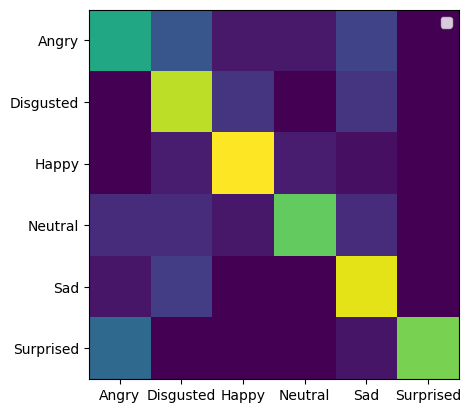

In [168]:
from typing import cast

confidences = model.predict(test_dataset)
predictions = np.argmax(confidences, axis=1)

labels = cast(list[int], list(test_dataset.unbatch().map(lambda x, y: y).as_numpy_iterator()))
target_names = retina.face.FacialExpressionLabel.target_names()

cmat = sklearn.metrics.confusion_matrix(labels, predictions, normalize="true")

plt.imshow(cmat)
plt.legend()
plt.xticks(range(len(target_names)), target_names)
plt.yticks(range(len(target_names)), target_names)

sklearn.metrics.classification_report(labels, predictions, output_dict=True, target_names=target_names)

In [169]:
model.save(retina.filesys.EXPRESSION_RECOGNITION_MODEL_PATH)

C:\Users\Davin Tristan\AppData\Local\Temp\ipykernel_22844\469801421.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  accuracy_fig.show()


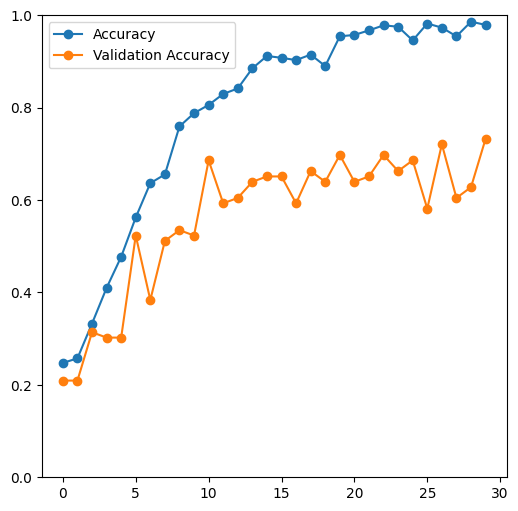

In [170]:
accuracy_fig = plt.figure(figsize=(6,6))
ax = accuracy_fig.add_subplot()
ax.plot(history.history["accuracy"], label="Accuracy", marker='o')
ax.plot(history.history["val_accuracy"], label="Validation Accuracy", marker='o')
ax.legend()
ax.set_ylim(0, 1)
accuracy_fig.show()